# CLIMATE 405: Machine Learning for Earth and Environmental Sciences; FALL 2024
## Prof. Mohammed Ombadi (ombadi@umich.edu)

# Lecture 4 (Monday, 09/09/2024)
# Topics covered in this lecture:
- Feature Selection (Continuous and Categorical Variables)
- Dimensionality Reduction 

## Import libraries

In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.integrate import odeint
from IPython.display import Image
from statistics import mode
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
import pingouin as pg

# Suppress warnings
warnings.filterwarnings('ignore')

# Set number of decimals for np print options
np.set_printoptions(precision=3)

# Set the current working directory
os.chdir(sys.path[0])

## <center>Feature Selection</center>

### What do we mean by "features"?

A feature is a measurable property or characteristic of the data used in a model. Features are the inputs that are fed into a machine learning algorithm to make predictions or classifications.

### 1- Example of a dataset with limited features (feature selection is not needed): 
Let's revisit the data from Lecture 3; that is, annual precipitation, evapotranspiration and streamflow from a single watershed

In [2]:
df = pd.read_csv('partial_correlation_data_annual.csv')
print(df.shape)
df.head()

(42, 4)


,year,P,S,E
0,1980,1003,3276,1260
1,1981,346,170,1395
2,1982,944,860,1208
3,1983,1111,2500,1190
4,1984,454,189,1313


If we want to use precipitation (P) and evapotranspiration (E) to predict streamflow (S), then we can visulaize the data using a simple scatterplot to see if P and E can be useful predictors of S:

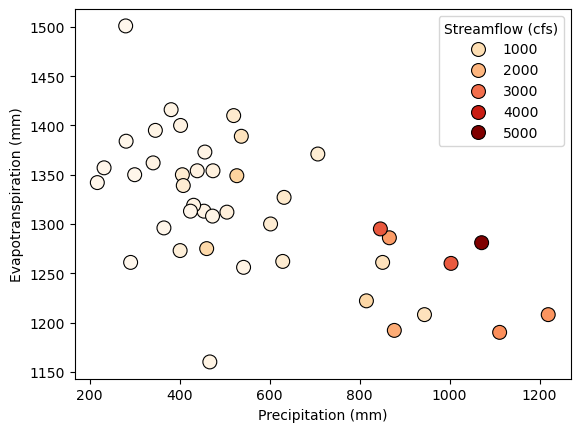

In [3]:
sns.scatterplot(data=df, x="P", y="E", hue="S", s=100, palette= 'OrRd', edgecolor= 'black')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Evapotranspiration (mm)')
plt.legend(title='Streamflow (cfs)')

It seems that Precipitation (**P**) and Evapotranspiration (**E**) are relatively good predictors for streamflow. Notice that high values of streamflow (dark orange and red) are mostly located in the lower right corner, whereas lower values of streamflow are mostly located in the upper left corner. 

In this case, we only have two predictors, which both seem to have a good explanatory power to be used in the model. However, this is not always the case. Sometimes, we have several potential predictors (multiple features), and we would like to select the most important features to be used in our machine learning model. Let's see an example:

### 2- Example of a continuous features and labels dataset: 
Let's examine the data "monthly_meteo_streamflow.csv". This is a data of monthly observations from January 1980 to December 2021, with the following details
- Target variable (S): Streamflow in units of cfs
- Features (A total of 8 features): P (Precipitation, mm); E (Evapotranspiration, mm); Tmean (mean daily temperature, C); Tmax (max daily temperature, C); Tmin (min daily temperature, C); Tdmean (Dew point temperature, C); vpdmax (max vapor pressure deficit, hpa); vpdmin (min vapor pressure deficit, hpa)

In [31]:
df = pd.read_csv('monthly_meteo_streamflow.csv')
print(df.shape)
df.head()

(504, 11)


,year,month,P,E,Tmean,Tmax,Tmin,Tdmean,vpdmax,vpdmin,S
0,1980,1,336.051600,19.272449,4.62255,8.74525,0.50080,-3.86055,6.40010,1.61600,423.612903
1,1980,2,418.161899,29.872766,5.51400,10.94060,0.08835,-5.08145,8.78265,1.89805,1685.965517
2,1980,3,154.332850,58.054099,4.03085,9.76090,-1.69825,-5.70805,8.08755,1.45430,609.161290
3,1980,4,19.936850,115.392255,8.77280,16.27545,1.27150,-5.28575,15.16410,2.41480,236.533333
4,1980,5,26.090900,116.888575,8.76150,15.23100,2.29315,0.08110,11.65045,1.13585,174.290323


__How can we select the relevant features for predicting S?__

- We can do this using the statistical dependence measures we discussed last lecture (e.g., Pearson's correlation coefficient, Spearman's correlation coefficient, Mutual Information, Partial Correlation ...etc.).
- This can be implemented using scikit-learn function __SelectKBest__ and some score functions: 


In [32]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [33]:
# Divide the dataset into features (X) and labels (y)
X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
#print(X.head())
#print(y.head())

#### 2a- Using the score function "f-regression"
This is similar to Pearson's correlation coefficient, detecting linear associtations

In [34]:
# Feature extraction
test = SelectKBest(score_func=f_regression, k=4)
fit = test.fit(X, y)

# Summarize scores
scores = pd.DataFrame(fit.scores_, index= df.columns[2:-1], columns= ['score'])
print('The scores for the features are = ', scores.sort_values(by= 'score', ascending= False))

The scores for the features are =               score
P       604.631855
vpdmax   62.162025
Tmax     60.565141
vpdmin   56.113101
Tmean    53.176189
E        45.211076
Tmin     42.819218
Tdmean    3.031612


In [35]:
# Selected features
features = df[scores.sort_values(by= 'score', ascending= False).index[0:4]]
print(features.shape)
print(features.head())

(504, 4)
            P    vpdmax      Tmax   vpdmin
0  336.051600   6.40010   8.74525  1.61600
1  418.161899   8.78265  10.94060  1.89805
2  154.332850   8.08755   9.76090  1.45430
3   19.936850  15.16410  16.27545  2.41480
4   26.090900  11.65045  15.23100  1.13585


#### 2b- Using the score function "mutual_info_regression"
This is the mutual information criteria we discussed in last lecture

In [36]:
# Feature extraction
test = SelectKBest(score_func=mutual_info_regression, k=4)
fit = test.fit(X, y)

# Summarize scores
scores = pd.DataFrame(fit.scores_, index= df.columns[2:-1], columns= ['score'])
print('The scores for the features are = ', scores.sort_values(by= 'score', ascending= False))

The scores for the features are =             score
vpdmin  0.375051
Tmean   0.318575
Tmin    0.312457
vpdmax  0.270351
Tmax    0.261143
P       0.243684
Tdmean  0.180127
E       0.168535


In [37]:
# Selected features
features = df[scores.sort_values(by= 'score', ascending= False).index[0:4]]
print(features.shape)
print(features.head())

(504, 4)
    vpdmin    Tmean     Tmin    vpdmax
0  1.61600  4.62255  0.50080   6.40010
1  1.89805  5.51400  0.08835   8.78265
2  1.45430  4.03085 -1.69825   8.08755
3  2.41480  8.77280  1.27150  15.16410
4  1.13585  8.76150  2.29315  11.65045


**Note:** _We end up getting almost two different sets of features depending on the score function we use for feature selection_

### 3- Example of a dataset with binary (categorical) variables for both features and labels:

- Let's examine the dataset _Zoo_. A simple dataset with 16 features and 1 label (target). The dataset has 101 observations, each corresponding to an animal. The label corresponds to animal class (from 1 to 7). You can find more information about the dataset and download it [here](https://archive.ics.uci.edu/dataset/111/zoo)

In [11]:
df = pd.read_csv('zoo_data.csv')
print('Number of features = ', df.iloc[:,1:-1].shape[1])
print('Number of observations = ', df.shape[0])
df.head()

Number of features =  16
Number of observations =  101


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


Now, we would like to select the 4 most important features that are needed to predict the class of an animal:

Because this is a categorical data, we need to use a different scoring function than the ones we used in section 3 of this lecture. In particular, we will be using _chi_2_, _mutual_info_classif_, and _f_classif_

#### 3a- Using the Chi_2 Scoring Function:

In [12]:
# Import the necessary libraries first
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif

In [13]:
# Divide the dataset into features (X) and labels (y)
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]
#print(X.head())
#print(y.head())

In [14]:
# Feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

# Summarize scores
scores = pd.DataFrame(fit.scores_, index= df.columns[1:-1], columns= ['score'])
print('The scores for the features are = ', scores.sort_values(by= 'score', ascending= False))

The scores for the features are =                score
legs      81.170621
feathers  81.000000
fins      62.553802
milk      60.000000
airborne  49.214736
hair      48.833806
eggs      37.419719
toothed   37.060056
aquatic   29.868970
catsize   20.976006
backbone  18.000000
venomous  17.589904
breathes  17.338750
tail      16.880439
predator   5.430810
domestic   4.192521


In [15]:
# Selected features
features = df[scores.sort_values(by= 'score', ascending= False).index[0:4]]
print(features.shape)
print(features.head())

(101, 4)
   legs  feathers  fins  milk
0     4         0     0     1
1     4         0     0     1
2     0         0     1     0
3     4         0     0     1
4     4         0     0     1


#### 3b- Using the Mutual Information Criteria for classification:

In [16]:
# Feature extraction
test = SelectKBest(score_func=mutual_info_classif, k=4)
fit = test.fit(X, y)

# Summarize scores
scores = pd.DataFrame(fit.scores_, index= df.columns[1:-1], columns= ['score'])
print('The scores for the features are = ', scores.sort_values(by= 'score', ascending= False))

The scores for the features are =               score
legs      1.070556
toothed   0.868947
backbone  0.648789
milk      0.609237
hair      0.593018
eggs      0.564201
tail      0.507597
feathers  0.486186
breathes  0.409521
aquatic   0.373220
airborne  0.291898
catsize   0.285803
fins      0.275514
domestic  0.011800
predator  0.000000
venomous  0.000000


In [17]:
# Selected features
features = df[scores.sort_values(by= 'score', ascending= False).index[0:4]]
print(features.shape)
print(features.head())

(101, 4)
   legs  toothed  backbone  milk
0     4        1         1     1
1     4        1         1     1
2     0        1         1     0
3     4        1         1     1
4     4        1         1     1


#### 3c- Using the f-classif (ANOVA) scoring function:
This is similar to Pearson's correlation coefficient, but for categorical variables

In [18]:
# Feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X, y)

# Summarize scores
scores = pd.DataFrame(fit.scores_, index= df.columns[1:-1], columns= ['score'])
print('The scores for the features are = ', scores.sort_values(by= 'score', ascending= False))

The scores for the features are =                 score
feathers         inf
milk             inf
backbone         inf
toothed   197.489319
eggs      127.992638
hair       83.465718
breathes   74.193354
fins       45.696191
tail       28.999226
airborne   27.749632
legs       19.766548
aquatic    13.320054
catsize     9.122367
venomous    3.654354
predator    2.150226
domestic    0.783735


In [19]:
# Selected features
features = df[scores.sort_values(by= 'score', ascending= False).index[0:4]]
print(features.shape)
print(features.head())

(101, 4)
   feathers  milk  backbone  toothed
0         0     1         1        1
1         0     1         1        1
2         0     0         1        1
3         0     1         1        1
4         0     1         1        1


Once again, we end up with a different set of important features depending on the specific scoring function (i.e., association measure) that we use.

Let's explore the cross-correlation between features for the Zoo dataset:

In [38]:
corr_matrix = df.iloc[:,1:-1].corr()

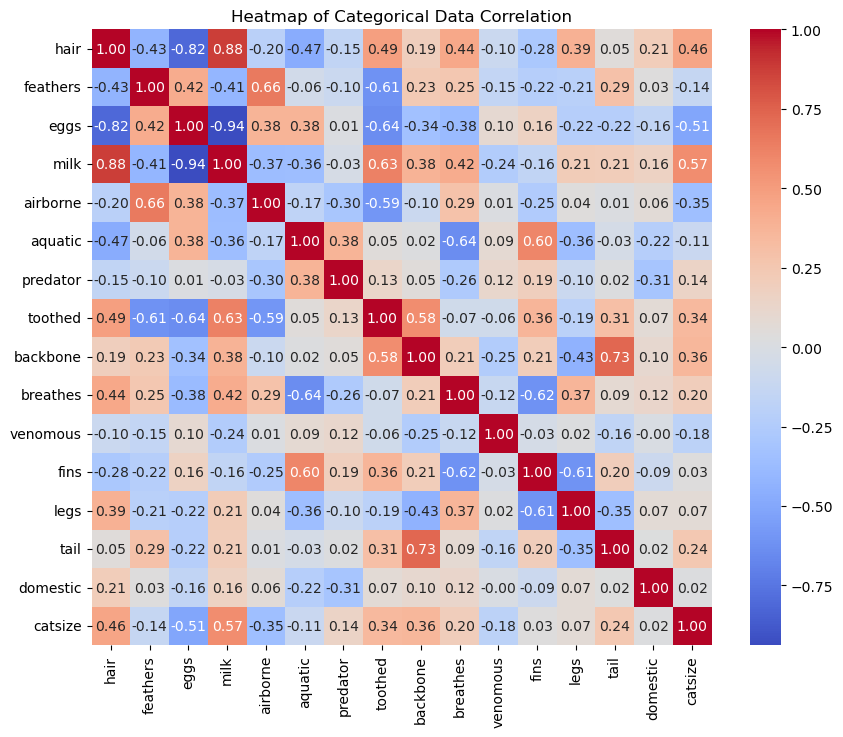

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Categorical Data Correlation')
plt.show()

### 4- Example of a dataset with a high-dimensional feature space:

_Copyright: This dataset comes from Brunton and Kutz 2017_ 

In [39]:
df = pd.read_csv('cat_dog_data.csv', header= None)
print(df.shape)

(4096, 160)


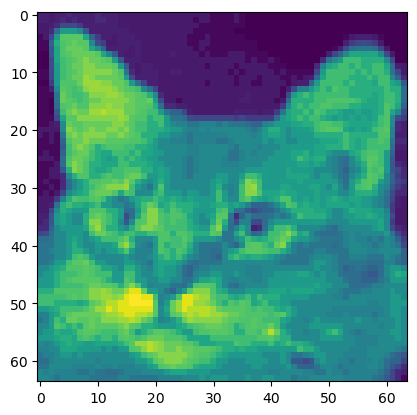

In [40]:
# Visualize one of the cat images (note: the first 80 columns correspond to cats)
plt.imshow((df.iloc[:,1].values).reshape((64,64), order= 'F'))

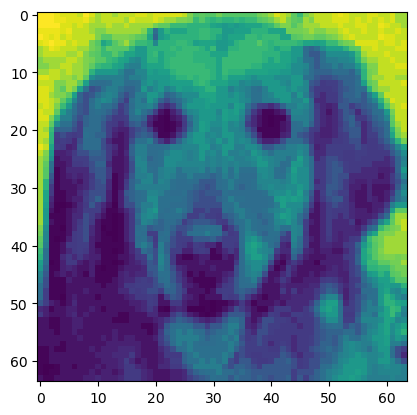

In [41]:
# Visualize one of the cat images (note: the first 80 columns correspond to cats)
plt.imshow((df.iloc[:,80].values).reshape((64,64), order= 'F'))

- This is a dataset with m-prime = 4096. Therefore, we would like to perform dimensionality reduction, and then use the obtained leading modes as our selected features.
- This can be done using Singular Value Decomposition (SVD).

In [42]:
# Set Features and Labels
# The features are the full dataset 'df'
X = np.transpose(np.copy(df.values))

# The labels are '0' for cats and '1' for dogs
y = (np.repeat([0, 1], 80))


# Perform Singular Value Decomposition
U, S, Vt = np.linalg.svd(np.transpose(X), full_matrices=False)

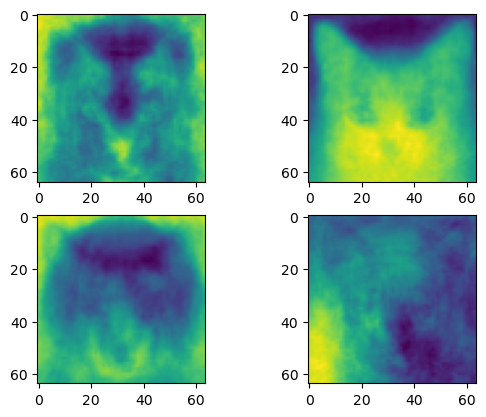

In [43]:
plt.subplot(2,2,1)
plt.imshow((U[:,0]).reshape((64,64), order= 'F'))

plt.subplot(2,2,2)
plt.imshow((U[:,1]).reshape((64,64), order= 'F'))

plt.subplot(2,2,3)
plt.imshow((U[:,2]).reshape((64,64), order= 'F'))

plt.subplot(2,2,4)
plt.imshow((U[:,3]).reshape((64,64), order= 'F'))

##### <center>**Plots for the SVD values associated with each sample for the 4 leading modes** </center>

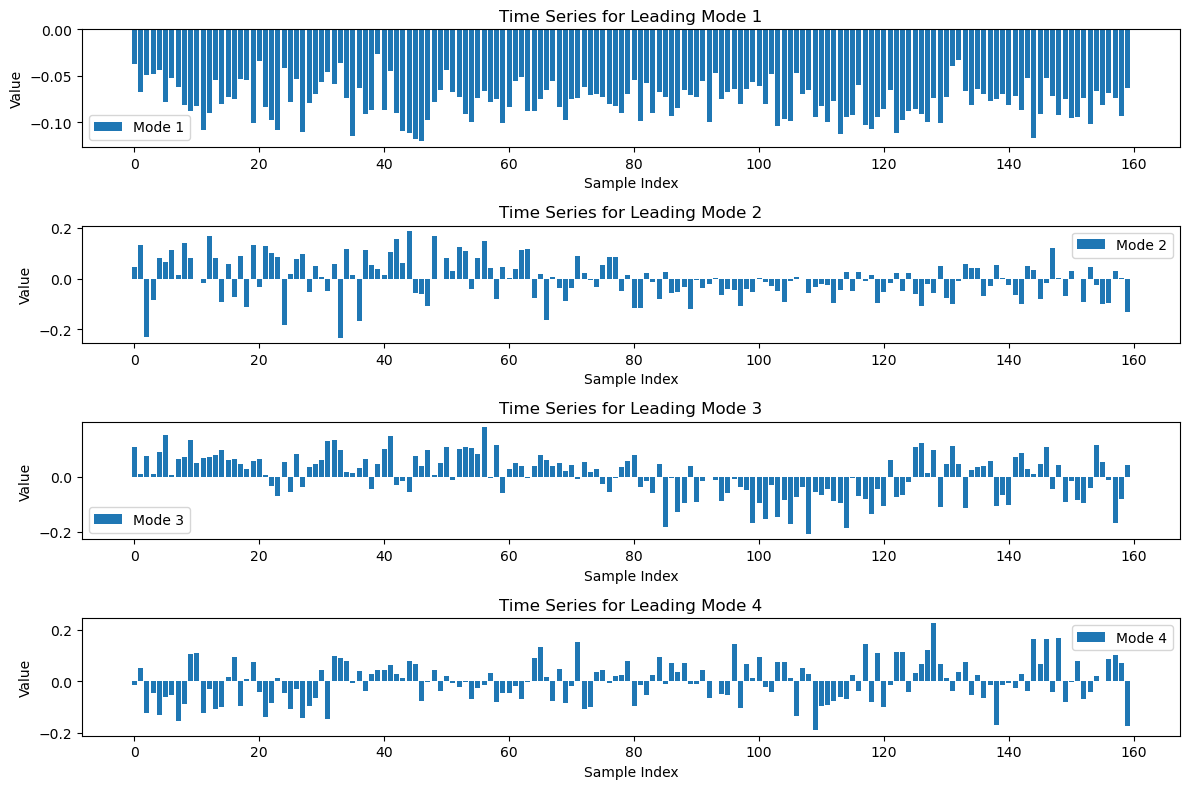

In [27]:
plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.bar(np.arange(Vt.shape[1]), Vt[i, :], label=f'Mode {i+1}')
    plt.title(f'Time Series for Leading Mode {i+1}')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()